# Predicting NBA Performance from G League Statistics using K-means Clustering and Linear Regression

Indiana Pacers Basketball Analytics Internship project. Written in Python 3.6.4 

The data shows positive correlation between G-league TS%, ORB%, STOCK% (average of BLK% and ST%) and NBA WS/48. Using a linear regression model with these G-league statistics as features, I predict G-league players' projected NBA WS/48 with an average error of 0.04.

The steps of the process are:
1. Download player season statistics from basketball-reference.com and save into a pandas dataframe
2. Clean the data, selecting only players which play more than 100 minutes in both the G-league and NBA in a given season.
3. Visualize the data using Seaborn, finding statistics which correlate from the G-league to the NBA
4. Use K-means clustering to re-position the players
5. Apply linear regression to predict NBA WS/48 from G-league statistics

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import csv
from sklearn import preprocessing, cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression
# Import `mean_absolute_error` from `sklearn.metrics`
from sklearn.metrics import mean_absolute_error

In [10]:
from mls import locate_data

## 1. Download and Clean NBA and G-league Data

NBA and G League season statistics were downloaded in CSV format from https://www.basketball-reference.com/

In order to account for the constantly evolving landscape of the NBA, only data from the 2014-15 season to the present season are considered. 2017-2018 statistics are up-to-date as of Friday, January 26th. In this project, only the advanced statistics on basketball-reference are used in order to minimize the effect of pace and teammates' performance on individual player statistics.

In the lines below, is a function **clean_data(nba_data, gleague_data, minutes_filter)** which filters out players with less than 100 minutes played in a given NBA or G League season to minimize noise.  

Note: In addition, some players have multiple entries due to playing for multiple teams in one season (e.g. Blake Griffin in the 17-18 season will have separate entries for "LAC", "DET", and "TOT" (for total season statistics)). This function removes these multiple entries and chooses only the "TOT" entry.

In [11]:
def clean_data(nba_data, gleague_data, minutes_filter):
    nba_filtered_data = nba_data[(nba_data['NBA_MP'] > minutes_filter)]
    gleague_filtered_data = gleague_data[(gleague_data['GLG_MP'] > minutes_filter)]
    
    nba_names = nba_filtered_data['NBA_Player']
    gleague_names = gleague_filtered_data['GLG_Player']
    duplicate_names = []
    for i, row in gleague_names.iteritems():
        for index, row_2 in nba_names.iteritems():
            if row_2.find(row) != -1:
                duplicate_names.append(row)
    gleague_names_filtered = gleague_filtered_data[(gleague_filtered_data['GLG_Player'].isin(duplicate_names))]
    gleague_duplicates_removed = gleague_names_filtered.sort_values('GLG_MP', ascending = False).drop_duplicates('GLG_Player').sort_index()

    duplicate_names_nba = []
    for i, row in gleague_names.iteritems():
        for index, row_2 in nba_names.iteritems():
            if row_2.find(row) != -1:
                duplicate_names_nba.append(row_2)
                
    nba_names_filtered = nba_filtered_data[(nba_filtered_data['NBA_Player'].isin(duplicate_names_nba))]
    nba_duplicates_removed = nba_names_filtered.sort_values('NBA_MP', ascending = False).drop_duplicates('NBA_Player').sort_index()
    
    return(nba_duplicates_removed, gleague_duplicates_removed)

First, I pass the '14-'15 statistics to the clean_data function. (Note that I am also creating a new statistic called "Stock%" which is the average of both the Block% and Steals% statistics)

In [12]:
nba_data_14_15 = pd.read_csv(locate_data('14_15_nba_data.csv'))
nba_data_14_15["NBA_STOCK%"] = ((nba_data_14_15['NBA_STL%'] + nba_data_14_15['NBA_BLK%']) / 2.)

n = 11
num_lines = sum(1 for l in open(locate_data('14_15_gleague_data.csv')))
skip_idx = [x for x in range(1, num_lines) if x % n == 0]
gleague_data_14_15 = pd.read_csv(locate_data('14_15_gleague_data.csv'),skiprows=skip_idx)
gleague_data_14_15["GLG_STOCK%"] = ((gleague_data_14_15['GLG_STL%'] + gleague_data_14_15['GLG_BLK%']) / 2.)
                           
nba_14_15_dataset, gleague_14_15_dataset = clean_data(nba_data_14_15, gleague_data_14_15, 100)


Then I do the same for '15-'16:

In [13]:
nba_data_15_16 = pd.read_csv(locate_data('15_16_nba_data.csv'))
nba_data_15_16["NBA_STOCK%"] = ((nba_data_15_16['NBA_STL%'] + nba_data_15_16['NBA_BLK%'])/2.)

n = 11
num_lines = sum(1 for l in open(locate_data('15_16_gleague_data.csv')))
skip_idx = [x for x in range(1, num_lines) if x % n == 0]
gleague_data_15_16 = pd.read_csv(locate_data('15_16_gleague_data.csv'),skiprows=skip_idx)
gleague_data_15_16["GLG_STOCK%"] = ((gleague_data_15_16['GLG_STL%'] + gleague_data_15_16['GLG_BLK%']) / 2.)
                           
nba_15_16_dataset, gleague_15_16_dataset = clean_data(nba_data_15_16, gleague_data_15_16, 100)


And for the '16-'17 dataset:

In [14]:
nba_data_16_17 = pd.read_csv(locate_data('16_17_nba_data.csv'))
nba_data_16_17["NBA_STOCK%"] = ((nba_data_16_17['NBA_STL%'] + nba_data_16_17['NBA_BLK%'])/2.)

n = 11
num_lines = sum(1 for l in open(locate_data('16_17_gleague_data.csv')))
skip_idx = [x for x in range(1, num_lines) if x % n == 0]
gleague_data_16_17 = pd.read_csv(locate_data('16_17_gleague_data.csv'),skiprows=skip_idx)
gleague_data_16_17["GLG_STOCK%"] = ((gleague_data_16_17['GLG_STL%'] + gleague_data_16_17['GLG_BLK%'])/2.)
                           
nba_16_17_dataset, gleague_16_17_dataset = clean_data(nba_data_16_17, gleague_data_16_17, 100)

And finally, the current season:

In [15]:
nba_data_17_18 = pd.read_csv(locate_data('17_18_nba_data.csv'))
nba_data_17_18["NBA_STOCK%"] = ((nba_data_17_18['NBA_STL%'] + nba_data_17_18['NBA_BLK%'])/2.)

n = 11
num_lines = sum(1 for l in open(locate_data('17_18_gleague_data.csv')))
skip_idx = [x for x in range(1, num_lines) if x % n == 0]
gleague_data_17_18 = pd.read_csv(locate_data('17_18_gleague_data.csv'),skiprows=skip_idx)
gleague_data_17_18["GLG_STOCK%"] = ((gleague_data_17_18['GLG_STL%'] + gleague_data_17_18['GLG_BLK%'])/2.)
                           
nba_17_18_dataset, gleague_17_18_dataset = clean_data(nba_data_17_18, gleague_data_17_18, 100)

Now I combine all the datasets:

In [16]:
nba_14_16_dataset = nba_14_15_dataset.append(nba_15_16_dataset)
nba_14_17_dataset = nba_14_16_dataset.append(nba_16_17_dataset)
nba_14_18_dataset = nba_14_17_dataset.append(nba_17_18_dataset)

gleague_14_16_dataset = gleague_14_15_dataset.append(gleague_15_16_dataset)
gleague_14_17_dataset = gleague_14_16_dataset.append(gleague_16_17_dataset)
gleague_14_18_dataset = gleague_14_17_dataset.append(gleague_17_18_dataset)

nba_reset = nba_14_18_dataset.reset_index(drop=True)
gleague_reset = gleague_14_18_dataset.reset_index(drop=True)
full_dataset = pd.concat([nba_reset, gleague_reset], axis=1)

Now, I have just one pandas dataset "full_dataset", which contains the NBA and G League individual season statistics for players which have played at least 100 minutes in both the G League and NBA for a given season between 2014-Present.

How many players fit this criteria?

In [17]:
full_dataset.shape

(170, 58)

Awesome! I have 170 data points to work with. That isn't a whole lot, but will be sufficient.

## 2. Data Visualization

For this project, I will use [seaborn](https://seaborn.pydata.org/index.html) since it is specifically designed for statistical data visualization. Specifically, it produces nice 2-D histograms and outputs the "pearsonr" value and "p" value for two given variables. The "pearsonr" value measures the [amount of correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between two variables, and "p" estimates the probability that they are uncorrelated. 

First, I'll look at how well some G-league statistics correlate to the NBA.

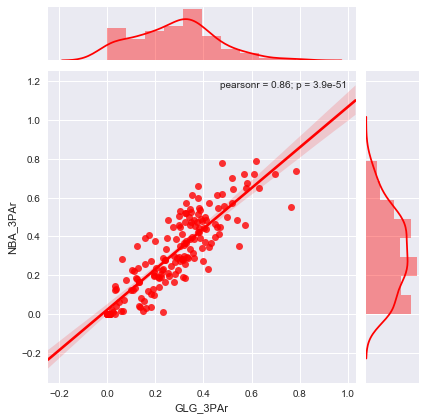

In [18]:
sns.jointplot('GLG_3PAr', 'NBA_3PAr', full_dataset, kind='reg', color='r')

Unsurprisingly, the three point attempt rate seems to correlate well from the G-league to the NBA. This just tells us that a 3-point shooter in the G-league will likely continue to try and shoot 3s in the NBA. 

Next I'll try the Free Throw Rate (FTr):

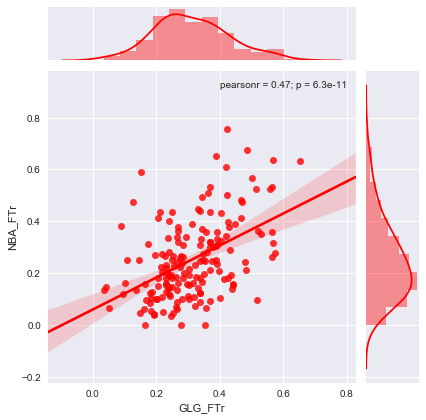

In [19]:
sns.jointplot('GLG_FTr', 'NBA_FTr', full_dataset, kind='reg', color='r')

The free throw rate is much noisier than the three point rate. This can possibly be explained in that a player's ability to draw fouls may not translate as well to the tougher and more athletic competition of the NBA.

To quantify the total success of a player I am using WS/48. While there is no perfect statistic in the NBA, I will use WS/48 as it accounts for both offense and defense, and it adjusts for pace.

How well does this statistic correlate from the G-league to the NBA?

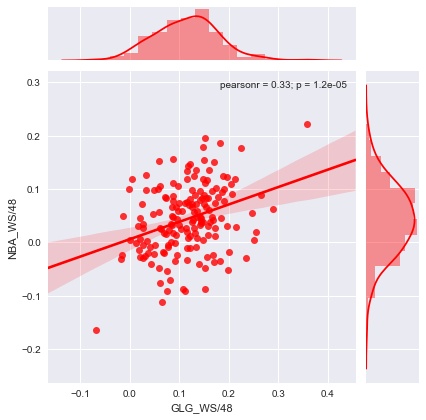

In [20]:
sns.jointplot('GLG_WS/48', 'NBA_WS/48', full_dataset, kind='reg', color='r')

This statistic translates to the NBA even worse than the Free throw rate! This just tells us that G-league success does not guarantee NBA success.

Are there any G-league statistics which might have correlation to NBA WS/48? 

To help with this, I'll again use Seaborn to now create "pair plots" of several G-league statistics with NBA_WS/48 

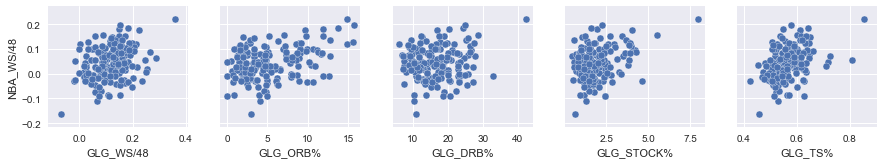

In [21]:
sns.pairplot(full_dataset,x_vars=('GLG_WS/48', 'GLG_ORB%','GLG_DRB%' ,'GLG_STOCK%', 'GLG_TS%'), y_vars=('NBA_WS/48'))

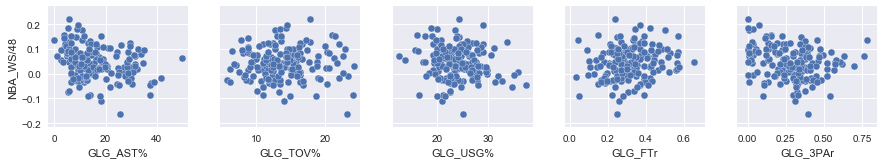

In [22]:
sns.pairplot(full_dataset,x_vars=('GLG_AST%','GLG_TOV%','GLG_USG%','GLG_FTr', "GLG_3PAr"), y_vars=('NBA_WS/48'))

From these plots, there is a positive correlation between G-league Offensive rebound percentage (ORB%), Stock percentage (STOCK%), and True shooting percentage (TS%) with NBA WS/48. 

This may be explained as higher ORB% and STOCK% both **corresponding to higher athleticism**.

Interestingly, there is a small amount of negative correlation between G-league assist percentage (AST%) and NBA WS/48, and almost no correlation between turnover percentage (TOV%) and NBA WS/48.

The non-correlation between G-league TOV% and NBA WS/48 may be indicative of players being asked to take on **different roles in the NBA**, such as handling the ball less. The slight negative correlation between G-league AST% and NBA WS/48 might be explained by more athletic G-league players taking advantage of their athleticism by passing less and scoring more. 

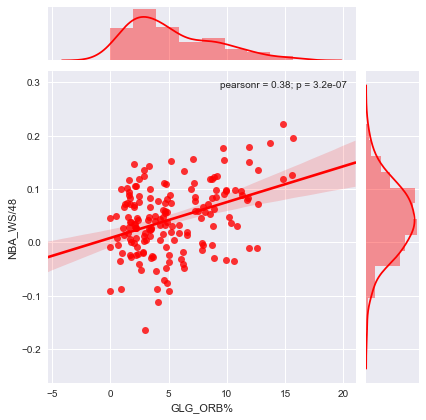

In [23]:
sns.jointplot('GLG_ORB%', 'NBA_WS/48', full_dataset, kind='reg', color='r')

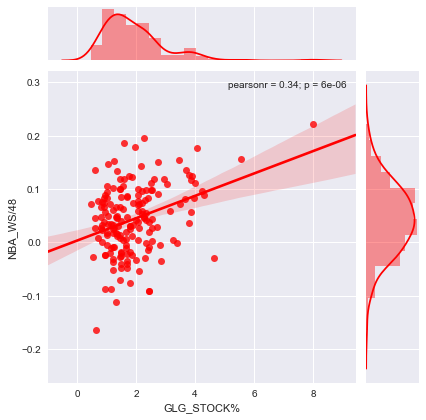

In [24]:
sns.jointplot('GLG_STOCK%', 'NBA_WS/48', full_dataset, kind='reg', color='r')

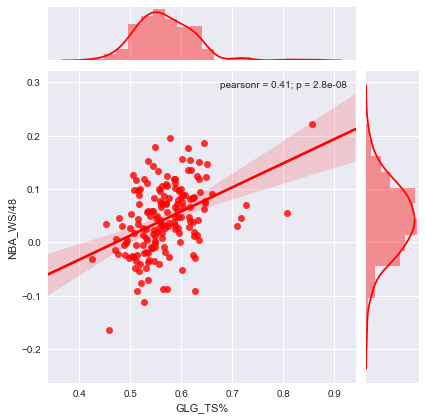

In [25]:
sns.jointplot('GLG_TS%', 'NBA_WS/48', full_dataset, kind='reg', color='r')

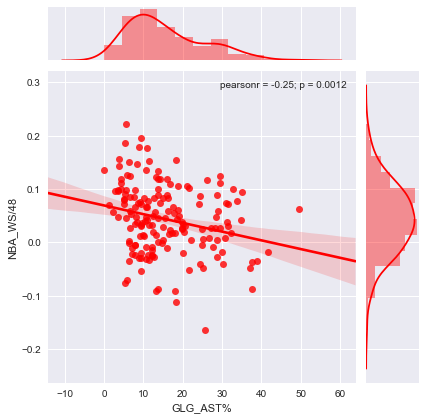

In [26]:
sns.jointplot('GLG_AST%', 'NBA_WS/48', full_dataset, kind='reg', color='r')

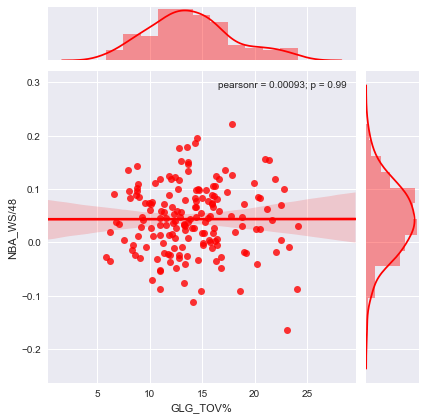

In [27]:
sns.jointplot('GLG_TOV%', 'NBA_WS/48', full_dataset, kind='reg', color='r')

## 3. K-Means Clustering 

It is useful to differentiate between different types of players. One could use the traditional "position" of the player, but this might not be the most accurate due to some players breaking away from the traditional features of each position (e.g Lebron James playing in many ways more like a PG than a SF).  

With K-means clustering from the [scikit-learn](http://scikit-learn.org/stable/) package I can use the G-league statistics to find positions.

K-means clustering separates the data into any number of clusters you ask it, and assigns each point to a cluster based on the distance between each point and the center of cluster.

Below I implement k-means clustering to the G-league data, separating into 3 clusters. The number 3 was chosen to separate the data into the positions:

1. Big Men
2. Wings
3. Point Guard

I then plot the distribution of the traditional positions of each cluster to see if the results fit the expected above.

In [28]:
def kmeans_fit(data, n_clusters):
    # Create K-means model and determine euclidian distances for each data point
    kmeans_model = KMeans(n_clusters, random_state=1)
    distances = kmeans_model.fit_transform(data)

    # Create scatter plot using labels from K-means model as color
    labels = kmeans_model.labels_

    plt.scatter(distances[:,0], distances[:,1], c=labels)
    plt.title('Kmeans Clusters')

    plt.show()
    return(labels)
    #attributes.append('labels')

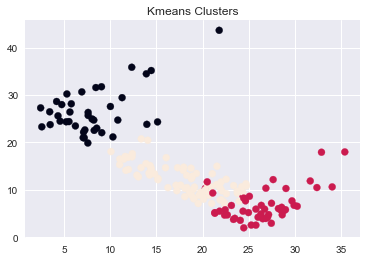

In [29]:
g_league_clustering_attributes = ['GLG_WS/48', 'GLG_TRB%', 'GLG_BLK%', 'GLG_STL%', 'GLG_TS%','GLG_AST%','GLG_FTr','GLG_TOV%','GLG_USG%']
gleague_data_attributes = full_dataset[g_league_clustering_attributes]
labels = kmeans_fit(gleague_data_attributes, 3)
full_dataset['GLG_positions'] = labels

In [30]:
full_dataset_0 = full_dataset[(full_dataset['GLG_positions'] == 0)]
full_dataset_1 = full_dataset[(full_dataset['GLG_positions'] == 1)]
full_dataset_2 = full_dataset[(full_dataset['GLG_positions'] == 2)]

Text(0,0.5,'Number of Players in Cluster 0')

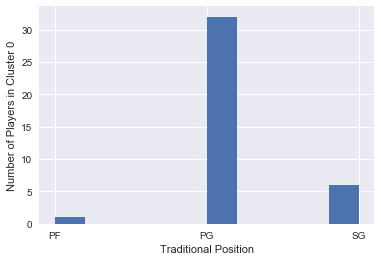

In [31]:
plt.hist(full_dataset_0['Pos'])
plt.xlabel('Traditional Position')
plt.ylabel('Number of Players in Cluster 0')

Text(0,0.5,'Number of Players in Cluster 1')

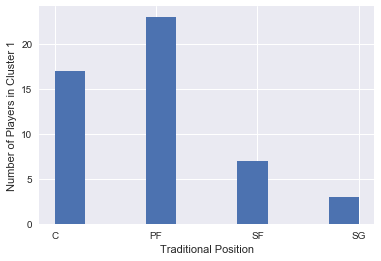

In [32]:
plt.hist(full_dataset_1['Pos'])
plt.xlabel('Traditional Position')
plt.ylabel('Number of Players in Cluster 1')

Text(0,0.5,'Number of Players in Cluster 2')

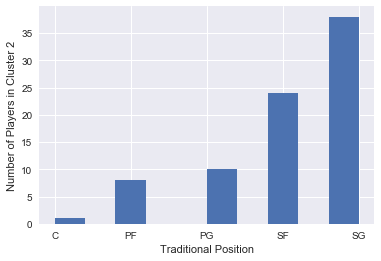

In [33]:
plt.hist(full_dataset_2['Pos'])
plt.xlabel('Traditional Position')
plt.ylabel('Number of Players in Cluster 2')

Looks pretty much as expected!

## 4. Linear Regression Prediction

Next, I'll use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to predict NBA WS/48. For features, I'll use G-league ORB%, STOCK%, TS%, WS/48, and AST%, as these statistics correlate best with NBA WS/48. I also include a separate feature for the positions I found using K-means clustering. 

To test the accuracy of my model, I'll separate the dataset into two subsets, the "train" dataset (consisting of 75% of the data) and the "test" dataset.

Using linear regression, I use the train dataset to find the function with the minimal error. Then I use the test dataset to see how accurately this function predicts future data.

Finally, I quote the "Mean Absolute Error" or the average difference between the predicted NBA WS/48 from the actual NBA WS/48 in the test dataset.

In [34]:
def linear_regression(dataset, predict_new_ws, ind_g_league_player_stats = []):
    cols_data = ['GLG_WS/48', 'GLG_ORB%', 'GLG_STOCK%', 'GLG_TS%','GLG_AST%','GLG_positions','NBA_WS/48']
    data = dataset[cols_data]
    train = data.sample(frac=0.75, random_state=1)
    test = data.loc[~data.index.isin(train.index)]

    attributes = ['GLG_WS/48', 'GLG_ORB%', 'GLG_STOCK%', 'GLG_TS%','GLG_AST%','GLG_positions']

    x_train = train[attributes]
    y_train = train['NBA_WS/48']
    x_test = test[attributes]
    y_test = test['NBA_WS/48']

    # Create Linear Regression model, fit model, and make predictions
              
    lr = LinearRegression(normalize=True)
    lr.fit(x_train, y_train)
    predictions = lr.predict(x_test)
    score = lr.score(x_test, y_test)

   
    if predict_new_ws:
        cols_data = ['GLG_WS/48', 'GLG_ORB%', 'GLG_STOCK%', 'GLG_TS%','GLG_AST%','GLG_positions']
        player_data = pd.DataFrame(columns = cols_data)
        player_data.loc[0] = ind_g_league_player_stats
        x_new = x_test.append(player_data, ignore_index=True)
        predictions_player = lr.predict(x_new)
        player_ws = predictions_player[-1]
        return(player_ws)


    # Determine mean absolute error
    mae = mean_absolute_error(y_test, predictions)
    print("Mean Absolute Error:")
    print(mae)

In [35]:
linear_regression(full_dataset, False)

Mean Absolute Error:
0.0400762796174


So this means the model is on average off by just 0.04 WS/48, not bad!

Next, this model can be used to make NBA predictions for current G-league players. 

First, I'll look at Jared Uthoff of the Fort Wayne Mad Ants. I'll assume he is in the "wings" category.

In [36]:
# [WS/48,ORB%,STOCK%,TS%,AST%,POS]
uthoff_array = [0.145,7.1,2.1,0.546,11.3,2]
uthoff_prediction = linear_regression(full_dataset,True,uthoff_array)
print("Uthoff Predicted NBA WS/48:")
print(uthoff_prediction)

Uthoff Predicted NBA WS/48:
0.0381348835866


How about 19 year old Ike Anigbogu?

In [37]:
anigbogu_array = [0.065,7.7,3.5,0.454,8.4,1]
anigbogu_prediction = linear_regression(full_dataset,True,anigbogu_array)
print("Anigbogu Predicted NBA WS/48:")
print(anigbogu_prediction)

Anigbogu Predicted NBA WS/48:
0.00561682742679


Lastly, how does current G-league WS/48 leader Xavier Gibson project?

In [38]:
gibson_array = [0.252,10.7,4.7,0.620,10.5,1]
gibson_prediction = linear_regression(full_dataset,True,gibson_array)
print("Gibson Predicted NBA WS/48:")
print(gibson_prediction)

Gibson Predicted NBA WS/48:
0.0818527653002


Looks like he projects to be an OK player, but doesn't appear to be the next Hassan Whiteside

# 5. Conclusion

I demonstrated predicting NBA performance from G-league statistics.

I found positive correlation between G-league TS%, STOCK%, and ORB% and NBA WS/48. The correlation between STOCK% and ORB% may be indicative of these statists corresponding to players of greater athleticism. No correlation is found between the G-league TOV% and NBA WS/48, suggesting that players often perform different roles in the two leagues.

Using these statistics, I repositioned the players using K-means clustering and trained a linear regression model to predict future NBA WS/48. Comparison of the model with a test dataset shows an average error of just 0.04 WS/48. 